In [45]:
# Pandas + Settings
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data Handling
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay

# Other
import warnings
warnings.filterwarnings('ignore')

In [54]:
af = pd.read_csv("./data/vanderbilt_ct_phenotype_2-14-23.csv")
outcomes = [col for col in af.columns if 'recur' in col.lower()]
valve_dx_cols = [col for col in af.columns if 'type_valve_dx' in col.lower()]
ablation_cols = [col for col in af.columns if 'ablation' in col.lower()]
af['la_any_modality'] = af['la_any_modality'].replace(".", None).astype('float')
af = af[af['la_any_modality'].notna()]

X = af.drop(outcomes + valve_dx_cols + ablation_cols, axis = 1).drop(['study_id', 'mri_ct'], axis = 1)
y = af['recurrence'].reset_index(drop=True)

In [55]:
def one_hot_encode(original_dataframe, feature_to_encode):
    original_dataframe[feature_to_encode] = original_dataframe[feature_to_encode].astype(str)
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_one_hot_encode = ['race', 'ethnicity']
for feature in features_to_one_hot_encode:
    X = one_hot_encode(X, feature)

features_to_binarize = X.select_dtypes('int64').columns

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) # this analysis keeps outliers as they are clinically meaningful

In [57]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [126]:
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=list(range(1, X_test.shape[0])))
grid = GridSearchCV(knn, param_grid, cv=10, scoring = 'roc_auc', return_train_score=False)
knn = grid.fit(X_train, y_train)
knn.best_params_

{'n_neighbors': 133}

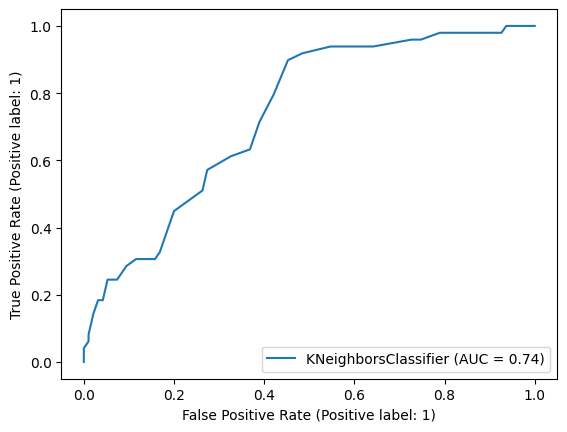

In [127]:
RocCurveDisplay.from_estimator(knn.best_estimator_, X_test, y_test)

In [123]:
estimator = XGBClassifier(objective= 'binary:logistic')

parameters = {
    'max_depth': range(2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.075, 0.05, 0.025, 0.01]
}
xgbc = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    return_train_score = False,
    n_jobs = 10,
    cv = 10)
xgbc.fit(X_train, y_train)
xgbc.best_params_

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}

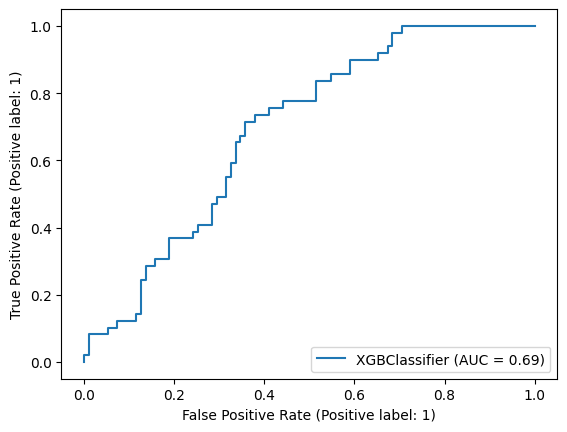

In [125]:
RocCurveDisplay.from_estimator(xgbc.best_estimator_, X_test, y_test)

In [ ]:
RocCurveDisplay.from_estimator(knn.best_estimator_, X_test, y_test)
plt.savefig("./clinicaldataROC.png")